In [33]:
import alignment, speech, applause_list, file_loader, text_features,re,models
import json, os, pickle, numpy as np
import librosa, pronouncing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from IPython.display import Audio
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, Dropout
import keras.optimizers
from keras.models import load_model
import keras.regularizers
from keras.regularizers import l2, l1

from keras.layers import LSTM
from keras.layers import regularizers
from keras.layers import Bidirectional

In [9]:
def initialize_model():
    return models.initialize_feed_forward_model(305,[600,100],loss='mean_squared_error',metrics=['mean_absolute_error'])

def initialize_binary_model():
    return models.initialize_feed_forward_model(300,[600,100],loss='binary_crossentropy',metrics=['accuracy'])

In [10]:
def initialize_lstm_model():
    return models.initialize_lstm_model(35,[25],loss='mean_squared_error',metrics=['mean_absolute_error'])

In [11]:
reload(speech)
reload(alignment)

<module 'alignment' from 'alignment.pyc'>

In [12]:
all_files = file_loader.get_non_duplicate_file_endings()
speeches = []
for f in tqdm(all_files):
    try:
        speeches.append(speech.Speech(f) )
    except:
        print f
speeches = [s for s in speeches if s.alignment.alignments is not None]
len(speeches)

100%|██████████| 354/354 [02:22<00:00,  4.59it/s]


311

In [21]:
s = speeches[155]
s.file_path

'bernie_sanders/bernie_sanders_46'

In [22]:
s.load_stored_crowd_rmse()

In [312]:
s.load_librosa_crowd()

In [313]:
s.load_librosa()

In [23]:
phrase_list = s.alignment.get_phrase_text_times_and_mean_applause_volume()

In [269]:
sent = phrase_list[2][0]
words = sent.split(' ')
words

[u'LET', u'ME', u'BEGIN', u'BY', u'THANKING']

In [171]:
phone_list = [pronouncing.phones_for_word(w.lower())[0] for w in words]

In [172]:
phone_list[0]

u'HH AE1 V IH0 NG'

In [134]:
for q in tqdm(range(300**2)):
    total_count = 0
    for i,p in enumerate(phone_list):
        for j,p2 in enumerate(phone_list):
            if i < j:
                total_count += count_matching_prefix_length(p,p2)
    total_count

100%|██████████| 90000/90000 [00:13<00:00, 6462.58it/s]


In [346]:
reload(text_features)

<module 'text_features' from 'text_features.py'>

In [348]:
#text_features.TextFeatures(sent).get_liwc_features()

In [332]:
words = tf.words

In [342]:
list(set(flatten([text_features.getLIWC(w.lower()) for w in words])))

['LIWC_focuspresent',
 'LIWC_pronoun',
 'LIWC_affect',
 'LIWC_relativ',
 'LIWC_verb',
 'LIWC_prep',
 'LIWC_time',
 'LIWC_ppron',
 'LIWC_function',
 'LIWC_i',
 'LIWC_auxverb']

In [338]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [319]:
list(set(text_features.getLIWC('whatever')))

['LIWC_pronoun',
 'LIWC_ipron',
 'LIWC_interrog',
 'LIWC_informal',
 'LIWC_netspeak',
 'LIWC_function']

In [317]:
text_features.TextFeatures(sent).get_euphony_features()

{'alliteration': 0.05555555555555555,
 'homogeneity': 0.16666666666666663,
 'plosive': 0.2777777777777778,
 'rhyme': 0.0}

In [334]:
i = 10
print phrase_list[i]
start = phrase_list[i][2]
end = start + 3
aud = s.y[int(start*s.sr):int(end*s.sr)]
crowd_aud = s.crowd_y[int(start*s.sr):int(end*s.sr)]
print np.mean(librosa.feature.rmse(crowd_aud))
Audio(aud,rate=22050)

[u'ON TO INSPIRE OUR NATION AND FIRST LADY', 2405.09, 2407.64, 0.0472252]
0.0468305


In [ ]:
plt.hist(s.rmse.T)

In [113]:
lstm_model = initialize_lstm_model()

In [107]:
time_series_lstm_model = initialize_lstm_model()

In [107]:
X_input = models.format_lstm_input(X_train)
y_input = y_train[5:]

test_X_input = models.format_lstm_input(X_test)
test_y_input = y_test[5:]

100%|██████████| 6476/6476 [00:00<00:00, 614184.57it/s]


In [108]:
X_input.shape

(25035, 5, 305)

In [109]:
len(y_input)

25035

In [110]:
time_series_lstm_model.fit(X_input[:,:,300:],np.array(y_input),batch_size=512,epochs=1)
time_series_lstm_model.evaluate(test_X_input[:,:,300:],np.array(test_y_input),batch_size=512)

Epoch 1/1
177165/177165 [==============================] - 1s     


[0.13296976335753785, 0.13296976369128216]

In [119]:
lstm_model.fit(X_input,np.array(y_input),batch_size=512,epochs=1)
lstm_model.evaluate(test_X_input,np.array(test_y_input),batch_size=512)

Epoch 1/1
4096/6476 [=================>............] - ETA: 0s

[0.085060485899264321, 0.24849336536818628]

In [101]:
weights = [layer.get_weights() for layer in time_series_lstm_model.layers]
weights[1]

NameError: name 'time_series_lstm_model' is not defined

In [284]:
test_X = np.zeros((5000,305))
test_y = np.zeros(5000)

In [ ]:
np.array(models.format_lstm_input(test_X)).shape

100%|██████████| 354/354 [02:17<00:00,  4.68it/s]


In [6]:
train_speeches, test_speeches = train_test_split(speeches,test_size=0.2, random_state=43)

NameError: name 'speeches' is not defined

In [9]:
min_difference = 0.4

In [237]:
X = []
y = []
for s in tqdm(train_speeches):
    preds = s.applause_preds_by_second
    for i in range(5,len(preds)):
        if (preds[i] - preds[i-1]) > min_difference or np.random.randint(16) == 1:
            raw_text = s.alignment.get_preceding_chars(i)
            if raw_text != '':
                tf = text_features.TextFeatures(raw_text)
                vec = tf.get_mean_vector(tf.sentences)
                lag = preds[i-5:i]
                vec = np.hstack([vec,lag])
                X.append(vec)
                y.append(preds[i])
X_train = X; y_train = y

100%|██████████| 248/248 [02:40<00:00,  3.02it/s]


In [238]:
X = []
y = []
for s in tqdm(test_speeches):
    preds = s.applause_preds_by_second
    for i in range(5,len(preds)):
        if (preds[i] - preds[i-1]) > min_difference or np.random.randint(16) == 1:
            raw_text = s.alignment.get_preceding_chars(i)
            if raw_text != '':
                tf = text_features.TextFeatures(raw_text)
                vec = tf.get_mean_vector(tf.sentences)
                lag = preds[i-5:i]
                vec = np.hstack([vec,lag])
                X.append(vec)
                y.append(preds[i])
X_test = X; y_test = y

100%|██████████| 63/63 [00:40<00:00,  1.80it/s]


In [152]:
#binary
X = []
y = []
for s in tqdm(train_speeches):
    preds = s.applause_preds_by_second
    for i in range(5,len(preds)):
        if (preds[i] - preds[i-1]) > min_difference:
            label = 1
        elif np.random.randint(16) == 1:
            label = 0 
        else:
            continue
        phrases = s.alignment.get_preceding_phrases(i,max_time=15)
        if len(phrases) > 0:
            vec = np.mean([nlp(p[0]).vector for p in phrases],axis=0)
            lag = preds[i-5:i]
            vec = np.hstack([vec,lag])
            X.append(vec)
            y.append(label)
X_train = X; y_train = y

100%|██████████| 248/248 [01:30<00:00,  5.20it/s]


In [153]:
#binary
X = []
y = []
for s in tqdm(test_speeches):
    preds = s.applause_preds_by_second
    for i in range(5,len(preds)):
        if (preds[i] - preds[i-1]) > min_difference:
            label = 1
        elif np.random.randint(16) == 1:
            label = 0 
        else:
            continue
        phrases = s.alignment.get_preceding_phrases(i,max_time=15)
        if len(phrases) > 0:
            vec = np.mean([nlp(p[0]).vector for p in phrases],axis=0)
            lag = preds[i-5:i]
            vec = np.hstack([vec,lag])
            X.append(vec)
            y.append(label)
X_test = X; y_test = y

100%|██████████| 63/63 [00:24<00:00,  3.26it/s]


In [110]:
def balance(X,y):
    X,y = shuffle(X,y)
    positive_indices = [i for i,lab in enumerate(y_train) if lab == 1]
    negative_indices = [i for i,lab in enumerate(y_train) if lab == 0]
    negative_indices = negative_indices[0:len(positive_indices)]
    X = [x for i,x in enumerate(X) if i in positive_indices or i in negative_indices]
    y = [x for i,x in enumerate(y) if i in positive_indices or i in negative_indices]
    return (X,y)

In [154]:
X_train, y_train = balance(X_train,y_train)
X_test, y_test = balance(X_test,y_test)

In [155]:
X_train = np.array(X_train)
X_test= np.array(X_test)

In [156]:
binary_model = initialize_binary_model()

In [186]:
binary_model.fit(X_train[:,0:300],y_train,batch_size=256,epochs=1)

Epoch 1/1
21010/21010 [==============================] - 0s - loss: 0.5984 - acc: 0.6836     


In [187]:
binary_model.evaluate(X_test[:,0:300],y_test)

8160/8474 [===========================>..] - ETA: 0s

[0.62549695377505166, 0.68055227777995619]

<module 'alignment' from 'alignment.pyc'>

In [283]:
s.load_librosa_crowd()

(u'IS SOME OF THAT REALITY NUMBER ONE', 296.86, 301.04)
0.01371


In [268]:
np.mean(s.rmse[0][int(start*s.frame_rate):int(end*s.frame_rate)])

0.013576838

In [241]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [357]:
clf=linear_model.LinearRegression()
clf.fit(X_train,y_train)
linreg_preds = clf.predict(X_test)
error = mean_absolute_error(linreg_preds, y_test)
print "error: %s\n" % error
print "Coefficients: " + str(clf.coef_[300:])
print "Intercept: " + str(clf.intercept_)

error: 0.238427827573

Coefficients: [ 0.02948558 -0.02874902  0.01832023 -0.16042732  0.82264358]
Intercept: 0.313430046567


In [356]:
clf=linear_model.LinearRegression()
clf.fit(X_train[:,300:],y_train)
linreg_preds = clf.predict(X_test[:,300:])
error = mean_absolute_error(linreg_preds, y_test)
print "error: %s\n" % error
print "Coefficients: " + str(clf.coef_)
print "Intercept: " + str(clf.intercept_)

error: 0.240324937447

Coefficients: [ 0.04315387 -0.02824202  0.02018902 -0.17056653  0.85306603]
Intercept: 0.23954758082


In [22]:
#with open('/data/corpora/cspan/x_train.pkl','r') as f:
#    X_train = pickle.load(f)

In [23]:
#with open('/data/corpora/cspan/x_test.pkl','r') as f:
#    X_test = pickle.load(f)

In [341]:
model = initialize_model()

In [354]:
model.fit(X_train,np.array(y_train),shuffle=True, batch_size=128, epochs=1,verbose=True)

Epoch 1/1
43911/43911 [==============================] - 2s - loss: 0.1997 - mean_absolute_error: 0.1997     


In [355]:
model.evaluate(X_test,np.array(y_test),batch_size=128)

 9216/11187 [=======================>......] - ETA: 0s

[0.1955402785985583, 0.19554027808706764]

In [143]:
np.mean(np.abs(model.predict(X_test[:,0:300],batch_size=256).reshape(np.array(y_test).shape)-np.array(y_test)))

0.26601857

In [149]:
np.mean(np.abs(np.full(len(y_test),np.mean(y_train))-y_test))

0.26533094

In [248]:
5*305

1525

In [156]:
X_train=np.array(X_train)
X_test = np.array(X_test)

In [ ]:
np.array(X_train)[:,-5:].shape

In [166]:
clf=linear_model.Ridge(alpha=0)
clf.fit(X_train,y_train)
linreg_preds = clf.predict(X_test)
error = mean_absolute_error(linreg_preds, y_test)
print "error: %s\n" % error
print "Coefficients: " + str(clf.coef_[-5:])

error: 0.112042740888

Coefficients: [ 0.00239686 -0.01917981  0.011392   -0.01185767  0.85748204]


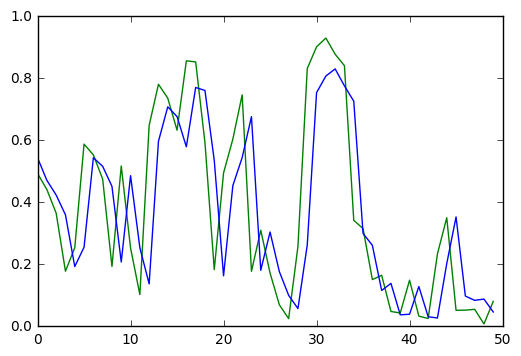

In [404]:
start = 500
end = start+50
plt.plot(y_test[start:end], color='green')
plt.plot(linreg_preds[start:end], color = 'blue')
plt.show()

In [428]:
lstm_model_preds = lstm_model.predict(test_X_input)
time_series_lstm_preds = time_series_lstm_model.predict(test_X_input[:,:,300:])

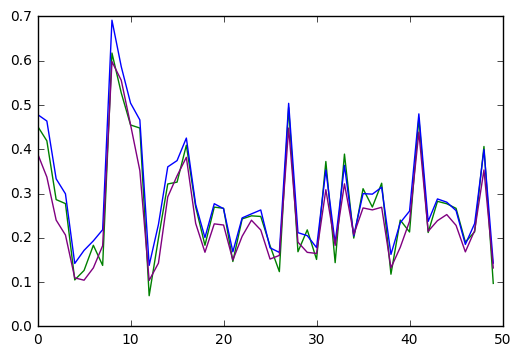

In [433]:
start = 1700
end = start + 50
plt.plot(test_y_input[start:end], color='green')
plt.plot(lstm_model_preds[start:end], color = 'blue')
plt.plot(time_series_lstm_preds[start:end], color = 'purple')
plt.show()

In [30]:


raw_text = s.alignment.get_preceding_chars(79)
raw_text

u"and three months ago it was my high honor to accept my party's nomination to run and in just one day to have the opportunity to serve as the next vice president of the United States the was. And I want to thank my friend Congressman Frank into. I want"

In [48]:
tf = text_features.TextFeatures(raw_text)
tf.sentences

[u"and  three  months  ago  it  was  my  high  honor  to  accept  my  party 's  nomination  to  run  and  in  just  one  day  to  have  the  opportunity  to  serve  as  the  next  vice  president  of  the  United  States  the  was . ",
 u'And  I  want  to  thank  my  friend  Congressman  Frank  into . ',
 u'I  want']

In [20]:
import numpy as np, re, spacy
nlp = spacy.load('en')

In [59]:
np.mean(np.array([nlp(sent).vector for sent in tf.sentences]),axis=0)

(300,)

In [51]:
n.vector

array([  2.50853989e-02,   5.58765382e-02,  -1.10743772e-02,
        -1.68480892e-02,   6.12825491e-02,  -4.88266870e-02,
        -4.16259728e-02,   1.35906762e-03,   2.14037057e-02,
         1.32676375e+00,  -1.01865567e-01,  -2.14839145e-03,
         4.68341112e-02,  -2.86373850e-02,  -6.80278987e-02,
        -4.84908484e-02,  -5.66921234e-02,   5.16139030e-01,
        -8.59587267e-02,   1.77103654e-02,  -3.41125811e-03,
        -4.55646515e-02,  -3.39471437e-02,  -7.64499838e-03,
        -1.80700012e-02,   2.78469529e-02,  -7.56080151e-02,
        -1.82580911e-02,  -2.37098988e-02,   3.11631877e-02,
         3.14707011e-02,   8.14324692e-02,  -3.12258909e-03,
         4.61970791e-02,   2.44393237e-02,  -4.40632664e-02,
        -1.97279043e-02,  -1.84566416e-02,  -3.52335051e-02,
        -3.21370810e-02,   3.31807323e-03,   5.58771640e-02,
         9.82258562e-03,  -7.07367212e-02,   4.12488393e-02,
         1.87425260e-02,  -6.01787120e-02,   6.94476301e-03,
         1.95381884e-03,

In [135]:
st = ' '.join(s.alignment.get_preceding_aligned_words(1800))

In [136]:
tf = text_features.TextFeatures(st)
tf.sentences

[u"it 's  great  to  be  back  here  i  remind  you  one  of  the  things  said  four  years  ago  was n't  that  big  of  an  issue  four  years  ago  commander  in  chief  is  not  an  entry  level  position  you  have  a  lot  of  wonderful  people  on  this  stage  but  very  few  of  them  very  few  them  have  the  experience"]